# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations


Defaulting to user installation because normal site-packages is not writeable


### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json 
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [ ]:
# Chemin d'accès complet au répertoire d'images
images_path = r'D:\Face_detection\data\images\*.jpg'

# Création de l'ensemble de données à partir des fichiers d'images
images = tf.data.Dataset.list_files(images_path)

In [ ]:
images.as_numpy_iterator().next()

In [3]:
def load_image(x): #x is the file path
    byte_img = tf.io.read_file(x) #tensorflow code to read our image, here return a byte encoded image
    img = tf.io.decode_jpeg(byte_img)  #tensorflow code to read our image
    return img

In [ ]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[ 60,  89, 103],
        [ 59,  88, 102],
        [ 58,  86,  98],
        ...,
        [ 42,  64,  75],
        [ 42,  64,  77],
        [ 40,  63,  77]],

       [[ 57,  86, 100],
        [ 56,  85,  99],
        [ 56,  84,  98],
        ...,
        [ 42,  62,  71],
        [ 40,  62,  75],
        [ 38,  61,  75]],

       [[ 57,  86, 102],
        [ 59,  88, 104],
        [ 60,  87, 104],
        ...,
        [ 42,  62,  71],
        [ 41,  63,  76],
        [ 40,  62,  75]],

       ...,

       [[135, 180, 213],
        [138, 184, 217],
        [140, 187, 217],
        ...,
        [  4,  11,  30],
        [ 10,  16,  40],
        [ 19,  25,  51]],

       [[137, 183, 216],
        [140, 186, 219],
        [141, 188, 218],
        ...,
        [ 10,  13,  30],
        [ 17,  19,  40],
        [ 27,  28,  49]],

       [[138, 184, 217],
        [140, 186, 219],
        [138, 187, 217],
        ...,
        [ 13,  16,  31],
        [ 21,  20,  38],
        [ 26,  24,  45]]

In [137]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator() #regroupe nos images

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

In [19]:
import os

# Création des répertoires 'data', 'train', 'test', 'val', 'images' et 'labels'
os.makedirs('data/train/images', exist_ok=True)
os.makedirs('data/train/labels', exist_ok=True)
os.makedirs('data/test/images', exist_ok=True)
os.makedirs('data/test/labels', exist_ok=True)
os.makedirs('data/val/images', exist_ok=True)
os.makedirs('data/val/labels', exist_ok=True)


In [111]:
import os
import shutil
import random

# Définir les chemins d'accès aux dossiers contenant les données
data_dir = 'data'
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

# Créer les dossiers train, test et val avec sous-dossiers images et labels s'ils n'existent pas déjà
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

for directory in [train_dir, test_dir, val_dir]:
    image_subdir = os.path.join(directory, 'images')
    label_subdir = os.path.join(directory, 'labels')
    if not os.path.exists(image_subdir):
        os.makedirs(image_subdir)
    if not os.path.exists(label_subdir):
        os.makedirs(label_subdir)

# Obtenez une liste de noms de fichiers d'images
image_files = os.listdir(images_dir)

# Mélangez aléatoirement les noms de fichiers pour répartir les données
random.shuffle(image_files)

# Calculez la taille de chaque ensemble
total_files = len(image_files)
train_size = int(0.7 * total_files)
test_size = int(0.15 * total_files)
val_size = total_files - train_size - test_size

# Répartir les fichiers d'images en ensembles d'entraînement, de test et de validation
train_files = image_files[:train_size]
test_files = image_files[train_size:train_size + test_size]
val_files = image_files[train_size + test_size:]

# Déplacer les fichiers d'images vers les dossiers correspondants
def move_files(files, destination):
    for file in files:
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, os.path.splitext(file)[0] + '.json')
        image_dst = os.path.join(destination, 'images', file)
        label_dst = os.path.join(destination, 'labels', os.path.splitext(file)[0] + '.json')
        
        if os.path.exists(image_src):
            shutil.move(image_src, image_dst)
        if os.path.exists(label_src):
            shutil.move(label_src, label_dst)

move_files(train_files, train_dir)
move_files(test_files, test_dir)
move_files(val_files, val_dir)

# Afficher des informations sur la répartition des images
print(f"Total images: {total_files}")
print(f"Train images: {len(train_files)}")
print(f"Test images: {len(test_files)}")
print(f"Val images: {len(val_files)}")
print("Images have been successfully split and moved!")


Total images: 120
Train images: 84
Test images: 18
Val images: 18
Images have been successfully split and moved!


In [67]:
import os

In [2]:
89*.7 # 62 to train

62.3

In [3]:
89*.15 # 14 and 13 to test and val

13.35

### 3.2 Move the Matching Labels

In [112]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [77]:
import albumentations as alb

In [78]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
    # Nouvelles transformations pour la détection de visages
    alb.Rotate(limit=20, p=0.5),
    alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    alb.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    alb.GaussNoise(p=0.5), 
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [68]:
import cv2
img = cv2.imread(os.path.join('data','train', 'images','0a71f1b0-1c1d-11ef-a331-548d5a0aa3dd.jpg'))

In [69]:
img

array([[[210, 232, 244],
        [209, 231, 243],
        [206, 230, 242],
        ...,
        [126, 113,  87],
        [124, 113,  86],
        [124, 113,  86]],

       [[208, 230, 242],
        [208, 230, 242],
        [206, 230, 242],
        ...,
        [125, 112,  86],
        [124, 113,  86],
        [123, 112,  85]],

       [[207, 229, 241],
        [207, 229, 241],
        [206, 230, 242],
        ...,
        [124, 112,  88],
        [123, 111,  87],
        [123, 111,  87]],

       ...,

       [[150, 146, 141],
        [150, 147, 139],
        [151, 147, 142],
        ...,
        [130, 116,  88],
        [130, 116,  88],
        [131, 117,  89]],

       [[152, 145, 142],
        [153, 147, 142],
        [154, 147, 144],
        ...,
        [131, 115,  86],
        [132, 116,  87],
        [132, 116,  87]],

       [[152, 145, 142],
        [153, 146, 143],
        [156, 147, 144],
        ...,
        [130, 114,  85],
        [131, 115,  86],
        [131, 115,  86]]

In [70]:
import json
with open(os.path.join('data', 'train', 'labels', '0a71f1b0-1c1d-11ef-a331-548d5a0aa3dd.json'), 'r') as f:
    label = json.load(f)

In [71]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[233.40782122905026, 2.290502793296102],
    [374.1899441340782, 180.50279329608938]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None},
  {'label': 'face',
   'points': [[472.5139664804469, 127.98882681564245],
    [471.9553072625698, 149.77653631284917]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\0a71f1b0-1c1d-11ef-a331-548d5a0aa3dd.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZna

In [14]:
label['shapes'][0]['points']

[[233.40782122905026, 2.290502793296102],
 [374.1899441340782, 180.50279329608938]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [79]:
coords = [0,0,0,0] #we store coordonates in this array
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [80]:
coords #we transformed the coordonates du dessus in a vector : [x1,y1,x2,y2], et là on a les coordonnées en pascal

[233.40782122905026, 2.290502793296102, 374.1899441340782, 180.50279329608938]

In [81]:
import numpy as np
coords = list(np.divide(coords, [640,480,640,480])) #on divise par width height of image pr normaliser

In [82]:
coords #albumentation format

[0.364699720670391,
 0.00477188081936688,
 0.5846717877094971,
 0.37604748603351956]

### 4.4 Apply Augmentations and View Results

In [83]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [84]:
augmented['bboxes']

[(0.636043589218993, 0.0, 0.9780522851630526, 0.2530780966078393)]

In [85]:
augmented['image'].shape #ditcionnaire ac infos données au dessus

(450, 450, 3)

In [86]:
augmented['bboxes'][0][2:]

(0.9780522851630526, 0.2530780966078393)

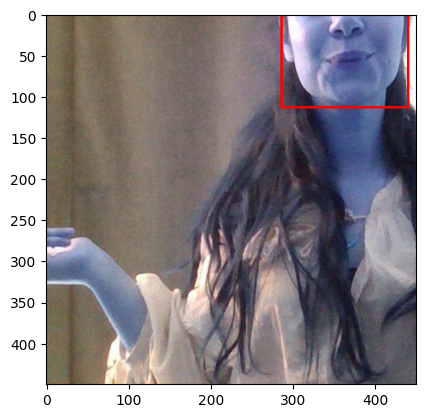

In [87]:
from matplotlib import pyplot as plt
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),#top coordonates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), #bottom coordonates
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [29]:
import os

# Créer le répertoire de sortie s'il n'existe pas déjà
output_dir = 'aug_data'
for partition in ['train', 'test', 'val']:
    images_output_dir = os.path.join(output_dir, partition, 'images')
    labels_output_dir = os.path.join(output_dir, partition, 'labels')
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(labels_output_dir, exist_ok=True)


In [88]:

#we will apply augmentation in all our data
import os
import cv2
import json
import numpy as np
import albumentations as alb



for partition in ['train','test','val']: #loop threw our 3 folders
    for image in os.listdir(os.path.join('data', partition, 'images')):#grap every image in these folders
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json') #if an annotation or not exists for this image (non positive images) if no anntofation we will add les values ds coords juste au dessus
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]#all of these is when annotations exist
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

##then we are creating 60 images per base image
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])#we doing our augmentation
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 #and assign a class of 0 if no annotation neg casis


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
              print(f"Error processing image {image}: {e}")

KeyboardInterrupt: 

In [20]:
import os

def count_images_in_subfolders(parent_folder):
    folder_counts = {}
    for subfolder in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, subfolder)
        if os.path.isdir(folder_path):
            image_count = len([f for f in os.listdir(os.path.join(folder_path, 'images')) if f.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))])
            folder_counts[subfolder] = image_count
    return folder_counts

# Exemple d'utilisation
aug_data_folder = 'aug_data'
subfolder_counts = count_images_in_subfolders(aug_data_folder)
print("Nombre d'images dans chaque sous-dossier de 'aug_data' :")
for folder, count in subfolder_counts.items():
    print(f"{folder}: {count} images")


Nombre d'images dans chaque sous-dossier de 'aug_data' :
test: 4260 images
train: 20100 images
val: 4320 images


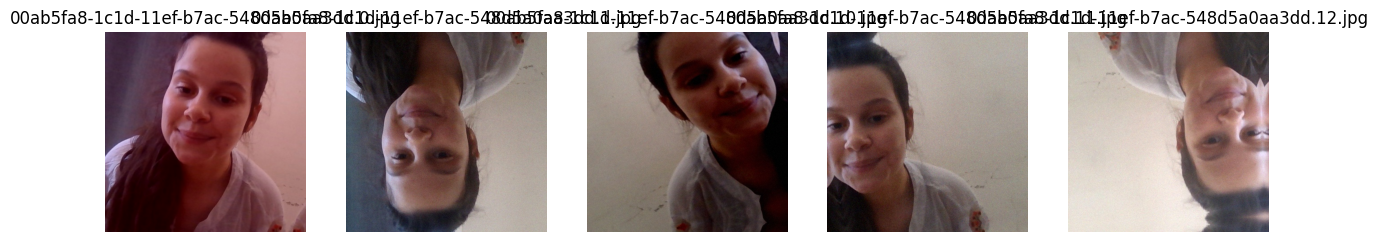

In [30]:
import os
import cv2
import matplotlib.pyplot as plt

def show_images_from_folder(folder, num_images=5):
    """
    Display a given number of images from a folder.
    
    Args:
    folder (str): The path to the folder containing images.
    num_images (int): The number of images to display.
    """
    image_files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = image_files[:num_images]
    
    plt.figure(figsize=(15, 10))
    
    for i, image_file in enumerate(selected_files):
        image_path = os.path.join(folder, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
    
    plt.show()

# Example usage: display images from 'aug_data/train/images'
show_images_from_folder('aug_data/train/images', num_images=5)


### 5.2 Load Augmented Images to Tensorflow Dataset

In [4]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False) #Our training images are going to be inside of a variable called train_images
train_images = train_images.map(load_image)
train_images = train_images.map(lambda X: tf.image.resize(X, (120,120)))
train_images = train_images.map(lambda X: X/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda X: tf.image.resize(X, (120,120)))
test_images = test_images.map(lambda X: X/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda X: tf.image.resize(X, (120,120)))
val_images = val_images.map(lambda X: X/255)

In [92]:
train_images.as_numpy_iterator().next()

array([[[0.10490196, 0.06568628, 0.06029412],
        [0.11862745, 0.07941177, 0.07401961],
        [0.09411765, 0.05490196, 0.0495098 ],
        ...,
        [0.58186275, 0.5348039 , 0.4877451 ],
        [0.5803922 , 0.53333336, 0.4862745 ],
        [0.5836397 , 0.5396446 , 0.49258578]],

       [[0.10361519, 0.06439951, 0.05704657],
        [0.11415441, 0.07493872, 0.06758578],
        [0.0877451 , 0.04852941, 0.04117647],
        ...,
        [0.5803922 , 0.5411765 , 0.49411765],
        [0.5817402 , 0.5425245 , 0.4954657 ],
        [0.58069855, 0.53658086, 0.48952207]],

       [[0.10851716, 0.06930147, 0.07322304],
        [0.12359069, 0.084375  , 0.08829657],
        [0.0911152 , 0.05189951, 0.05496323],
        ...,
        [0.5764706 , 0.5372549 , 0.49019608],
        [0.5838235 , 0.5446078 , 0.49754903],
        [0.5841299 , 0.5449142 , 0.4978554 ]],

       ...,

       [[0.28645834, 0.30998775, 0.37273285],
        [0.28627452, 0.30980393, 0.3647059 ],
        [0.28327206, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda X: tf.py_function(load_labels, [X], [tf.uint8, tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda X: tf.py_function(load_labels, [X], [tf.uint8, tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda X: tf.py_function(load_labels, [X], [tf.uint8, tf.float16]))

In [100]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.06757, 0.2927 , 0.534  , 0.948  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [103]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(20100, 20100, 4260, 4260, 4320, 4320)

### 7.2 Create Final Datasets (Images/Labels)

In [11]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(20100)
train = train.batch(8) #each patch will represent 8 images and 8 labels
train = train.prefetch(4)

In [12]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(4260)
test = test.batch(8)
test = test.prefetch(4)

In [13]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(4320)
val = val.batch(8)
val = val.prefetch(4)

In [107]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2012 , 0.0912 , 0.749  , 0.858  ],
        [0.4536 , 0.4072 , 0.9575 , 1.     ],
        [0.     , 0.2407 , 0.4607 , 0.889  ],
        [0.2634 , 0.5493 , 0.487  , 0.852  ],
        [0.2042 , 0.2089 , 0.6274 , 0.704  ],
        [0.1406 , 0.10754, 0.859  , 0.975  ],
        [0.0762 , 0.306  , 0.4312 , 0.8022 ],
        [0.8413 , 0.2477 , 1.     , 0.809  ]], dtype=float16))

In [ ]:
len(images)

### 7.3 View Images and Annotations

In [108]:
data_samples = train.as_numpy_iterator()

In [109]:
type(data_samples)

tensorflow.python.data.ops.dataset_ops._NumpyIterator

In [111]:
res = data_samples.next()

In [112]:
res[1][1][0]

array([0., 0., 0., 0.], dtype=float16)

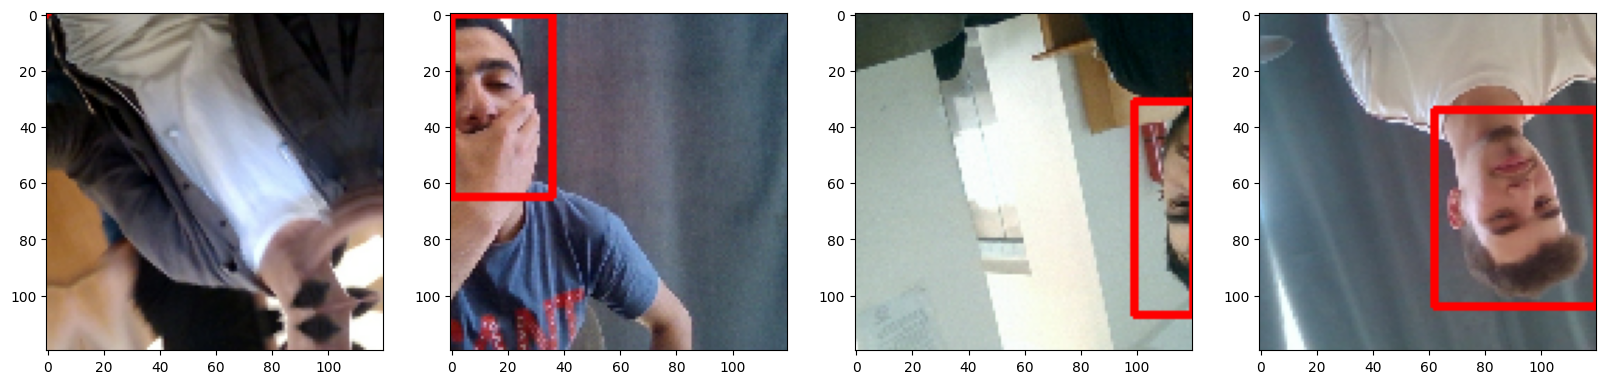

In [113]:
from PIL import Image
import numpy as np

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (res[0][idx]*255).astype(np.uint8)
    #copy_image = sample_image.copy()
    #print(copy_image.shape)
    sample_coords = res[1][1][idx]
    #copy_image = copy_image.astype(np.int32)
    #cv2.rectangle(sample_image, (20,10), (60,60), (255,0,0), 4)
    #print()
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)